# 04 · Resumen y visualización de resultados

Este notebook inspecciona los **resultados de entrenos** y las **métricas continual**:

- Lee `outputs/continual_*/*/manifest.json` (o `metrics.json` si existiera) por **tarea**.
- Lee `outputs/continual_*/continual_results.json` por **run** (forgetting, MAE, etc.).
- Muestra un **DataFrame** y algunos **gráficos rápidos**.

> Requisitos:
> - Haber ejecutado `03_TRAIN_CONTINUAL.ipynb` (para que existan `continual_*` y sus JSON).
> - Estructura de salida por defecto en `./outputs/`.



## 1) Imports y rutas base


In [7]:
from pathlib import Path
import json, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

# Raíz del repo (soporta ejecutar desde notebooks/ o raíz)
ROOT = Path.cwd().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()

import sys
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

OUT = ROOT / "outputs"
print("ROOT:", ROOT); print("OUT :", OUT)


ROOT: /home/cesar/proyectos/TFM_SNN
OUT : /home/cesar/proyectos/TFM_SNN/outputs


## 2) Utilidades de parseo y lectura robusta

- `safe_read_json`: abre JSON y devuelve `{}` si no existe o está corrupto.
- `parse_exp_name`: extrae preset, método, encoder, semilla y modelo del nombre `continual_*`.
- `find_first_file`: busca un fichero (p.ej. `manifest.json` o `metrics.json`) en una carpeta.


In [8]:
# Utilidades canónicas (parseo, lectura, dataframe y agregados)
from src.utils_exp import parse_exp_name, safe_read_json, build_runs_df, aggregate_and_show
print("[INFO] Usando utilidades de src.utils_exp")

# Helper local (nos sirve para rascar history por tarea)
from pathlib import Path
def find_first_file(folder: Path, candidates=("manifest.json", "metrics.json")) -> Path | None:
    for c in candidates:
        p = folder / c
        if p.exists():
            return p
    return None


[INFO] Usando utilidades de src.utils_exp


## 3) Resumen “continual” (por run)

Lee `continual_results.json` en cada carpeta `outputs/continual_*` y computa:
- `c1_mae`, `c1_after_c2_mae`, `forgetting_abs`, `forgetting_rel_%`, `c2_mae`.



In [9]:
# Resumen por experimento (usa build_runs_df)
df_runs = build_runs_df(OUT)
print(f"runs en resumen: {len(df_runs)}")

if df_runs.empty:
    display(df_runs)
else:
    display(
        df_runs.sort_values(
            ["preset","method","encoder","lambda","seed"],
            na_position="last", ignore_index=True
        )
    )

# (Opcional) además, guarda el agregado bonito en outputs/summary/
_ = aggregate_and_show(df_runs, OUT)


runs en resumen: 21


,exp,preset,method,lambda,encoder,model,seed,c1_name,c2_name,c1_mae,c1_after_c2_mae,c1_forgetting_mae_abs,c1_forgetting_mae_rel_%,c2_mae,lambda_num
0,continual_fast_ewc_lam_1e+09_lam_1e+09_rate_mo...,fast,ewc,1e+09,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.143431,0.147171,0.003740,2.607426,0.257968,1.000000e+09
1,continual_fast_ewc_lam_1e+09_lam_1e+09_rate_mo...,fast,ewc,1e+09,rate,PilotNetSNN_66x200_gray,43,circuito1,circuito2,0.174228,0.170924,-0.003305,-1.896875,0.222932,1.000000e+09
2,continual_fast_ewc_lam_2e+09_lam_2e+09_rate_mo...,fast,ewc,2e+09,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.155467,0.146814,-0.008653,-5.565735,0.270587,2.000000e+09
3,continual_fast_ewc_lam_3e+08_lam_3e+08_rate_mo...,fast,ewc,3e+08,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.155467,0.152690,-0.002777,-1.786268,0.239508,3.000000e+08
4,continual_fast_ewc_lam_4e+08_lam_4e+08_rate_mo...,fast,ewc,4e+08,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.155516,0.157668,0.002153,1.384201,0.263156,4.000000e+08
5,continual_fast_ewc_lam_6e+08_lam_6e+08_rate_mo...,fast,ewc,6e+08,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.156865,0.173882,0.017018,10.848712,0.286293,6.000000e+08
6,continual_fast_ewc_lam_7e+08_lam_7e+08_rate_mo...,fast,ewc,7e+08,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.142933,0.144072,0.001139,0.796674,0.268332,7.000000e+08
7,continual_fast_ewc_lam_8e+08_lam_8e+08_rate_mo...,fast,ewc,8e+08,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.155467,0.145578,-0.009889,-6.360858,0.257729,8.000000e+08
8,continual_fast_ewc_lam_9e+08_lam_9e+08_rate_mo...,fast,ewc,9e+08,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.155467,0.147286,-0.008181,-5.262219,0.261564,9.000000e+08
9,continual_fast_ewc_lam_4e+08_lam_4e+08_ewc_hpo...,fast,ewc_ewc_hpo_t0_lam_4.3e+08,4e+08,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.145400,0.170480,0.025080,17.248765,0.248004,4.000000e+08


,exp,preset,method,lambda,encoder,model,seed,c1_name,c2_name,c1_mae,c1_after_c2_mae,c1_forgetting_mae_abs,c1_forgetting_mae_rel_%,c2_mae,lambda_num
0,continual_fast_ewc_lam_3e+08_lam_3e+08_rate_mo...,fast,ewc,3e+08,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.155467,0.152690,-0.002777,-1.786268,0.239508,3.000000e+08
1,continual_fast_ewc_lam_4e+08_lam_4e+08_rate_mo...,fast,ewc,4e+08,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.155516,0.157668,0.002153,1.384201,0.263156,4.000000e+08
2,continual_fast_ewc_lam_6e+08_lam_6e+08_rate_mo...,fast,ewc,6e+08,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.156865,0.173882,0.017018,10.848712,0.286293,6.000000e+08
3,continual_fast_ewc_lam_7e+08_lam_7e+08_rate_mo...,fast,ewc,7e+08,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.142933,0.144072,0.001139,0.796674,0.268332,7.000000e+08
4,continual_fast_ewc_lam_8e+08_lam_8e+08_rate_mo...,fast,ewc,8e+08,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.155467,0.145578,-0.009889,-6.360858,0.257729,8.000000e+08
5,continual_fast_ewc_lam_9e+08_lam_9e+08_rate_mo...,fast,ewc,9e+08,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.155467,0.147286,-0.008181,-5.262219,0.261564,9.000000e+08
6,continual_fast_ewc_lam_1e+09_lam_1e+09_rate_mo...,fast,ewc,1e+09,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.143431,0.147171,0.003740,2.607426,0.257968,1.000000e+09
7,continual_fast_ewc_lam_1e+09_lam_1e+09_rate_mo...,fast,ewc,1e+09,rate,PilotNetSNN_66x200_gray,43,circuito1,circuito2,0.174228,0.170924,-0.003305,-1.896875,0.222932,1.000000e+09
8,continual_fast_ewc_lam_2e+09_lam_2e+09_rate_mo...,fast,ewc,2e+09,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.155467,0.146814,-0.008653,-5.565735,0.270587,2.000000e+09
9,continual_fast_ewc_lam_4e+08_lam_4e+08_ewc_hpo...,fast,ewc_ewc_hpo_t0_lam_4.3e+08,4e+08,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.145400,0.170480,0.025080,17.248765,0.248004,4.000000e+08


Guardado: /home/cesar/proyectos/TFM_SNN/outputs/summary/continual_summary_agg.csv


,preset,método,codificador,λ,MAE Tarea1 (media),Olvido T1 (%) (media),MAE Tarea2 (media),MAE Tarea1 (σ),Olvido T1 (%) (σ),MAE Tarea2 (σ),n (semillas)
0,fast,ewc,rate,3e+08,0.1555,-1.7863,0.2395,,,,1
1,fast,ewc,rate,4e+08,0.1555,1.3842,0.2632,,,,1
2,fast,ewc,rate,6e+08,0.1569,10.8487,0.2863,,,,1
3,fast,ewc,rate,7e+08,0.1429,0.7967,0.2683,,,,1
4,fast,ewc,rate,8e+08,0.1555,-6.3609,0.2577,,,,1
5,fast,ewc,rate,9e+08,0.1555,-5.2622,0.2616,,,,1
6,fast,ewc,rate,1e+09,0.1588,0.3553,0.2405,0.0218,3.1850,0.0248,2
7,fast,ewc,rate,2e+09,0.1555,-5.5657,0.2706,,,,1
8,fast,ewc_ewc_hpo_t0_lam_4.3e+08,rate,4e+08,0.1454,17.2488,0.2480,,,,1
9,fast,ewc_ewc_hpo_t1_lam_7.9e+08,rate,8e+08,0.1429,1.7231,0.2674,,,,1


## 4) Resumen de entrenamiento por tarea (manifest/metrics)

Busca carpetas `outputs/continual_*/*task_*` y lee el `manifest.json` (o `metrics.json`) para extraer:
- `epochs`, `batch_size`, `lr`, `amp`, `seed`, y últimas pérdidas (`train_loss`, `val_loss`).


In [10]:
task_rows = []
for exp_dir in sorted(OUT.glob("continual_*")):
    for task_dir in sorted(exp_dir.glob("task_*")):
        jf = find_first_file(task_dir)
        if jf is None:
            continue
        man = safe_read_json(jf)
        # Estructura esperada (del parche): {"epochs","batch_size","lr","amp","seed","history":{"train_loss":[...],"val_loss":[...]}}
        history = man.get("history", {})
        train_hist = history.get("train_loss", [])
        val_hist   = history.get("val_loss", [])
        task_rows.append({
            "exp": exp_dir.name,
            "task": task_dir.name,
            "epochs": man.get("epochs"),
            "batch_size": man.get("batch_size"),
            "lr": man.get("lr"),
            "amp": man.get("amp"),
            "seed": man.get("seed"),
            "train_last": train_hist[-1] if train_hist else np.nan,
            "val_last": val_hist[-1] if val_hist else np.nan,
        })

df_tasks = pd.DataFrame(task_rows)
print(f"tareas encontradas: {len(df_tasks)}")
display(df_tasks.sort_values(["exp","task"], ignore_index=True) if not df_tasks.empty else df_tasks)


tareas encontradas: 42


,exp,task,epochs,batch_size,lr,amp,seed,train_last,val_last
0,continual_fast_ewc_lam_1e+09_lam_1e+09_ewc_hpo...,task_1_circuito1,2,64,0.001,True,42,0.042110,0.034551
1,continual_fast_ewc_lam_1e+09_lam_1e+09_ewc_hpo...,task_2_circuito2,2,64,0.001,True,42,9.462700,0.151705
2,continual_fast_ewc_lam_1e+09_lam_1e+09_ewc_hpo...,task_1_circuito1,2,64,0.001,True,42,0.042110,0.034551
3,continual_fast_ewc_lam_1e+09_lam_1e+09_ewc_hpo...,task_2_circuito2,2,64,0.001,True,42,7.345351,0.145947
4,continual_fast_ewc_lam_1e+09_lam_1e+09_rate_mo...,task_1_circuito1,2,64,0.001,True,42,0.043325,0.033891
5,continual_fast_ewc_lam_1e+09_lam_1e+09_rate_mo...,task_2_circuito2,2,64,0.001,True,42,3.649817,0.124621
6,continual_fast_ewc_lam_1e+09_lam_1e+09_rate_mo...,task_1_circuito1,2,64,0.001,True,43,0.334728,0.051335
7,continual_fast_ewc_lam_1e+09_lam_1e+09_rate_mo...,task_2_circuito2,2,64,0.001,True,43,6.062807,0.102937
8,continual_fast_ewc_lam_2e+09_lam_2e+09_rate_mo...,task_1_circuito1,2,64,0.001,True,42,0.037983,0.041455
9,continual_fast_ewc_lam_2e+09_lam_2e+09_rate_mo...,task_2_circuito2,2,64,0.001,True,42,7.129906,0.136392


## 5) Gráficos rápidos

- Barras de `c1_mae` por experimento.
- Barras de “olvido relativo (%)” cuando esté disponible.


/tmp/ipykernel_259548/2906561882.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


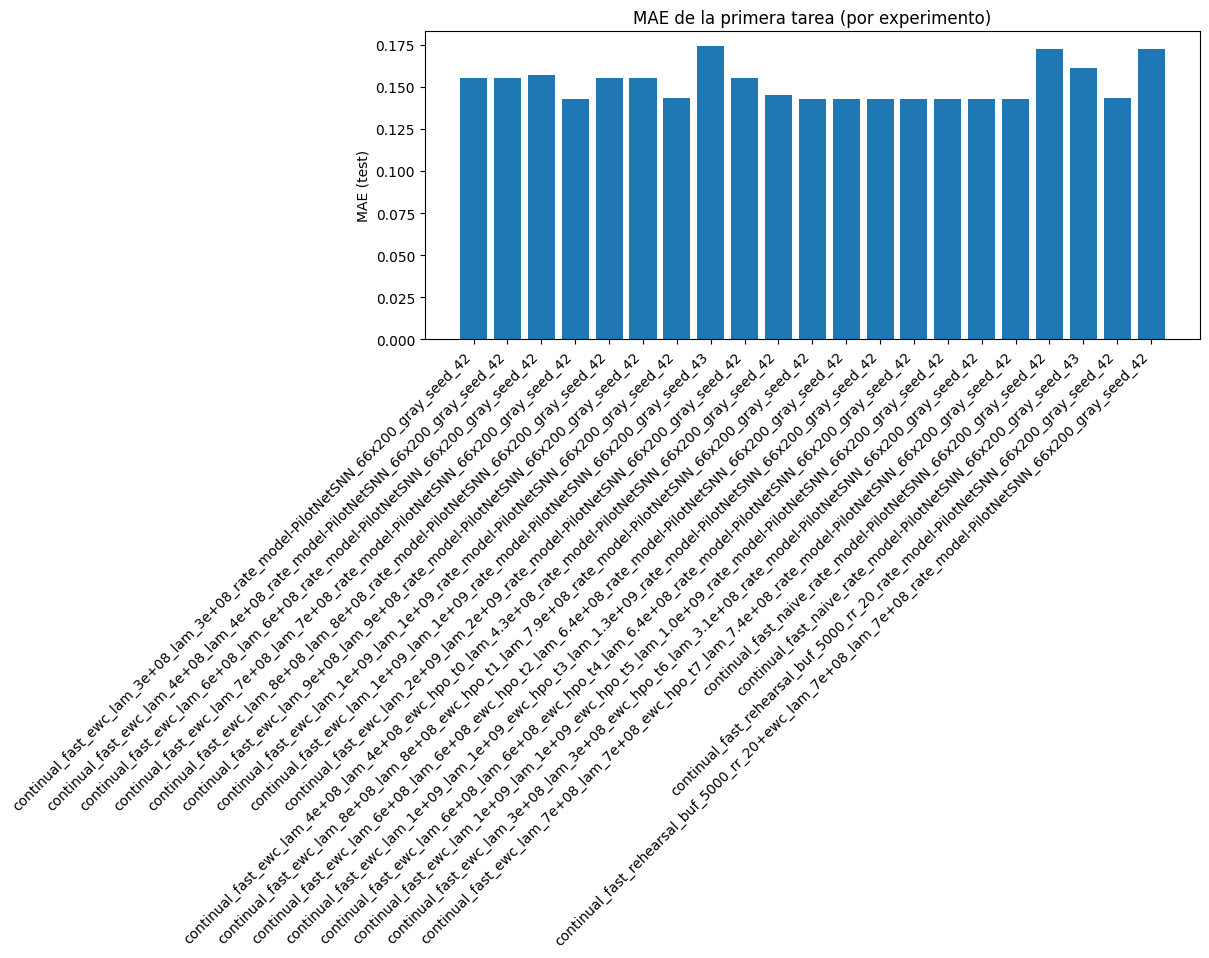

/tmp/ipykernel_259548/2906561882.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


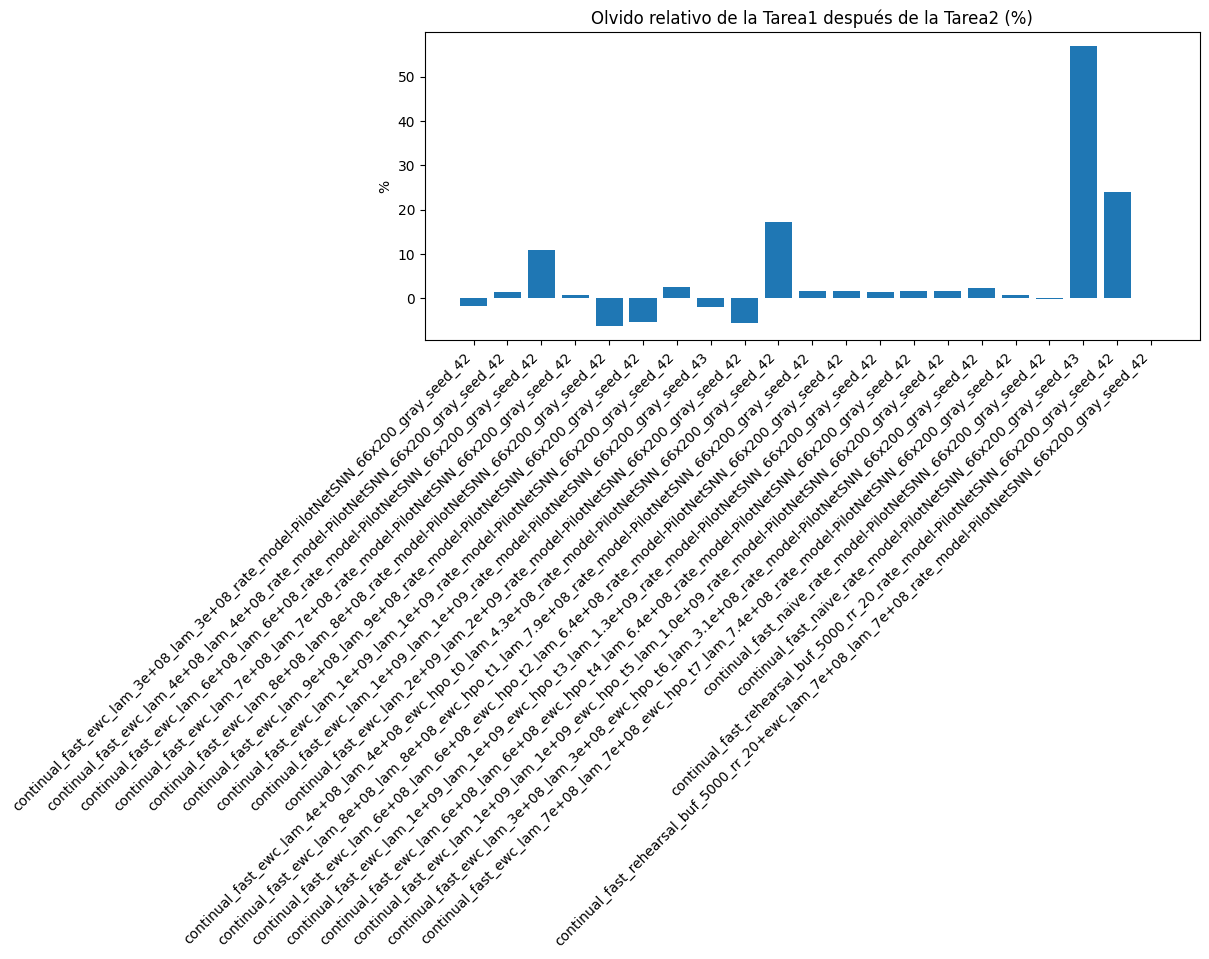

In [11]:
if df_runs.empty:
    print("No hay datos en df_runs; ejecuta entrenos en 03_TRAIN_CONTINUAL.ipynb primero.")
else:
    order = df_runs["exp"].tolist()

    plt.figure(figsize=(10,4))
    plt.bar(order, df_runs["c1_mae"])
    plt.title("MAE de la primera tarea (por experimento)")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("MAE (test)")
    plt.tight_layout()
    plt.show()

    if "c1_forgetting_mae_rel_%" in df_runs.columns and df_runs["c1_forgetting_mae_rel_%"].notna().any():
        plt.figure(figsize=(10,4))
        plt.bar(order, df_runs["c1_forgetting_mae_rel_%"])
        plt.title("Olvido relativo de la Tarea1 después de la Tarea2 (%)")
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("%")
        plt.tight_layout()
        plt.show()


## 6) Inspección de un experimento concreto

Imprime el contenido de `continual_results.json` para un `exp` de interés (por defecto el más reciente).


In [12]:
# Escoge el más reciente o pon manualmente un nombre de carpeta continual_*
exps = sorted(OUT.glob("continual_*"), key=lambda p: p.stat().st_mtime, reverse=True)
if not exps:
    print("No hay carpetas continual_* en outputs/.")
else:
    exp_dir = exps[0]   # cámbialo si quieres otro
    cfile = exp_dir / "continual_results.json"
    print("Mostrando:", cfile if cfile.exists() else "(no existe continual_results.json)")
    if cfile.exists():
        pprint(safe_read_json(cfile))


Mostrando: /home/cesar/proyectos/TFM_SNN/outputs/continual_fast_ewc_lam_7e+08_lam_7e+08_ewc_hpo_t7_lam_7.4e+08_rate_model-PilotNetSNN_66x200_gray_seed_42/continual_results.json
{'circuito1': {'after_circuito2_mae': 0.14407366092559087,
               'after_circuito2_mse': 0.0344635056116123,
               'test_mae': 0.14293317359107352,
               'test_mse': 0.034013658314692496},
 'circuito2': {'test_mae': 0.26833168388694845,
               'test_mse': 0.11858616857118504}}
